In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/MyDrive/twitter_sentiment')

## Install Packages

In [ ]:
!pip install nltk
!pip install emot==3.1

## Import Packages

In [ ]:
import nltk
nltk.download(['punkt', 'stopwords'])

In [5]:
import pandas as pd
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

## Load Data

In [7]:
STOPWORDS_FILEPATH = "data/stop_words.txt"
SAVE_WORD_CLOUD_FILEPATH = "results/yzsb_v2/Yapay Zeka Stratejisi_2021-08-20_2021-08-25_{0}_wordcloud_v2_freq.png"

In [8]:
df = pd.read_csv("data/Yapay_Zeka_Stratejisi_2021_08_20_2021_08_25_df_sentiment_analysis_all.csv")
df

Unnamed: 0  Unnamed: 0.1  ...  sentiment_label sentiment_score
0             0             0  ...         negative          0.6704
1             1             1  ...         positive          0.9017
2             2             2  ...         positive          0.9990
3             3             3  ...         positive          0.5813
4             4             4  ...         negative          0.6870
..          ...           ...  ...              ...             ...
657         657           657  ...         negative          0.7368
658         658           658  ...         negative          0.8500
659         659           659  ...         negative          0.7597
660         660           660  ...         positive          0.9103
661         661           661  ...         negative          0.8053

[662 rows x 9 columns]

In [9]:
df_positive = pd.read_csv("data/Yapay_Zeka_Stratejisi_2021_08_20_2021_08_25_df_sentiment_analysis_positive.csv")
df_positive

Unnamed: 0  Unnamed: 0.1  ...  sentiment_label sentiment_score
0            2             2  ...         positive          0.9990
1           11            11  ...         positive          0.9763
2           16            16  ...         positive          0.9746
3           20            20  ...         positive          0.9616
4           26            26  ...         positive          0.9614
..         ...           ...  ...              ...             ...
69         581           581  ...         positive          0.9887
70         586           586  ...         positive          0.9581
71         595           595  ...         positive          0.9728
72         614           614  ...         positive          0.9842
73         631           631  ...         positive          0.9820

[74 rows x 9 columns]

In [10]:
df_negative = pd.read_csv("data/Yapay_Zeka_Stratejisi_2021_08_20_2021_08_25_df_sentiment_analysis_negative.csv")
df_negative

Unnamed: 0  Unnamed: 0.1  ...  sentiment_label sentiment_score
0            5             5  ...         negative          0.9978
1           14            14  ...         negative          0.9994
2           35            35  ...         negative          0.9987
3           59            59  ...         negative          0.9912
4          105           105  ...         negative          0.9887
5          219           219  ...         negative          0.9867
6          221           221  ...         negative          0.9813
7          223           223  ...         negative          0.9688
8          250           250  ...         negative          0.9989
9          255           255  ...         negative          0.9905
10         271           271  ...         negative          0.9967
11         285           285  ...         negative          0.9757
12         299           299  ...         negative          0.9533
13         310           310  ...         negative          0.9752
14         418           418  ...         negative          0.9986
15         472           472  ...         negative          0.9878
16         477           477  ...         negative          0.9982
17         479           479  ...         negative          0.9750
18         480           480  ...         negative          0.9929
19         507           507  ...         negative          0.9986
20         555           555  ...         negative          0.9905
21         582           582  ...         negative          0.9990
22         634           634  ...         negative          0.9652
23         656           656  ...         negative          0.9897

[24 rows x 9 columns]

## Preprocess 

In [11]:
import re
import sys
from nltk.stem.porter import PorterStemmer
from emot.emo_unicode import UNICODE_EMOJI
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [13]:
def get_stopwords_list():
    s_words = []
    w_file = open(STOPWORDS_FILEPATH, encoding="utf-8")
    
    for word in w_file:
        word = word.strip()
        
        s_words.append(word)

    s_words.append("‚Ä¢")
    s_words.append("20212025")
    s_words.append("saat")
    s_words.append("10.00da")
    s_words.append("nde")

    w_file.close()

    return s_words

In [14]:
# https://medium.com/geekculture/text-preprocessing-how-to-handle-emoji-emoticon-641bbfa6e9e7


##Torku Konyaspor silinecek

def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;``')
    
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)|üòâ', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)

    return tweet


def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', string)


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    
    #Clean only digits
    tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet)
    
    # Replaces URLs with the word URL
    #tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', tweet)
    
    # Replace @handle with the word USER_MENTION
    #tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    tweet = re.sub(r'@[\S]+', '', tweet)
    
    # Replaces #hashtag with hashtag
    #tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    tweet = re.sub(r'#(\S+)', '', tweet)
    
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')

    # Replace emojis with either EMO_POS or EMO_NEG
    #tweet = handle_emojis(tweet)
    tweet = remove_emoji(tweet)
   
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)

    #my custom chars
    tweet = tweet.replace('‚Ç∫','')
    tweet = tweet.replace('=','')
    tweet = tweet.replace('‚Äô','')
    tweet = tweet.replace('|','')
    tweet = tweet.replace('‚Äò','')
    tweet = tweet.replace('/','')
    tweet = tweet.replace('‚Ä¶','')
    tweet = tweet.replace('‚Äì','')
    tweet = tweet.replace('&','')
    tweet = tweet.replace('‚Äú','')
    tweet = tweet.replace('‚Äù','')
    tweet = tweet.replace('+','')
    tweet = tweet.replace('%','')
    tweet = tweet.replace('@','')
    tweet = tweet.replace('#','')
    tweet = tweet.replace('iÃá','i')

    words = word_tokenize(tweet) #tweet.split()

    for word in words:
      word = preprocess_word(word)
      #if is_valid_word(word):
      #    processed_tweet.append(word)
      processed_tweet.append(word)

    return ' '.join(processed_tweet)

## Generate Word Cloud

In [16]:
def generate_word_cloud_from_frequencies(freq_dict, status):
    
    # adding movie script specific stopwords
    stop_words = get_stopwords_list()

    #print(stop_words)

    #print(len(fdist_filtered))

    wordcloud = WordCloud(
        width=1200, 
        height=800, 
        background_color="black", 
        max_words=200, 
        min_font_size=10,
        stopwords = stop_words).generate_from_frequencies(frequencies=freq_dict)
    
    plt.figure(figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

    wordcloud.to_file(SAVE_WORD_CLOUD_FILEPATH.format(status))

In [17]:
stop_words = get_stopwords_list()
len(stop_words)

315

## ALL

In [18]:
df.tweet

0      T√ºrkiye'nin Yapay Zeka Stratejisi... Ulusal Ya...
1      A√ßƒ±klanan T√ºrkiye Yapay Zeka Stratejisi ile il...
2      @ZB6868 @firstjedii @varank Bence biraz abs√ºrd...
3      T√ºrkiye‚Äônin ƒ∞lk Ulusal Yapay Zeka Stratejisi a...
4      T√ºrkiye'nin ƒ∞lk Ulusal Yapay Zeka Stratejisi a...
                             ...                        
657    Bug√ºnk√º resmi gazete ile  ‚ÄúUlusal Yapay Zeka S...
658    Bug√ºnk√º Resmi Gazete'de (20.08.2021 T-31574 sa...
659    Ulusal Yapay Zek√¢ Stratejisi (2021-2025) ile ƒ∞...
660    Yapay zeka alanƒ±nda √ßalƒ±≈üan arkada≈ülar i√ßin √∂n...
661    Ulusal Yapay Zek√¢ Stratejisi (2021-2025) ile ƒ∞...
Name: tweet, Length: 662, dtype: object

In [19]:
tweet_all_texts = " ".join(t for t in df.tweet)
print("Yapay Zeka Stratejisi twitlerinin tamamƒ± {0} adet kelimeden olu≈üuyor".format(len(tweet_all_texts)))

Yapay Zeka Stratejisi twitlerinin tamamƒ± 99826 adet kelimeden olu≈üuyor


In [20]:
tweet_positive_texts = " ".join(t for t in df_positive.tweet)
print("Yapay Zeka Stratejisi pozitif twitlerinin tamamƒ± {0} adet kelimeden olu≈üuyor".format(len(tweet_positive_texts)))

Yapay Zeka Stratejisi pozitif twitlerinin tamamƒ± 15929 adet kelimeden olu≈üuyor


In [21]:
tweet_negative_texts = " ".join(t for t in df_negative.tweet)
print("Yapay Zeka Stratejisi negatif twitlerinin tamamƒ± {0} adet kelimeden olu≈üuyor".format(len(tweet_negative_texts)))

Yapay Zeka Stratejisi negatif twitlerinin tamamƒ± 4557 adet kelimeden olu≈üuyor


In [22]:
tweet_all_texts

'T√ºrkiye\'nin Yapay Zeka Stratejisi... Ulusal Yapay Zeka Stratejisi Bili≈üim Vadisi\'nde tanƒ±tƒ±ldƒ±  https://t.co/zIFA33C8Ij A√ßƒ±klanan T√ºrkiye Yapay Zeka Stratejisi ile ilgili   \u2066@fusunnebil\u2069 √ßok g√ºzel bir deƒüerlendirme yapmƒ±≈ü.   #yapayzekastratejisi #yapayzeka #strateji #dijltalt√ºrkiye #dijitalvatan #dijitalt√ºrkiyetv  https://t.co/BXdPUyaEWO @ZB6868 @firstjedii @varank Bence biraz abs√ºrd bir d√º≈ü√ºnce bu :)  Yapay zeka ≈üuan hayatƒ±mƒ±zda zaten mevcut aslƒ±nda... Bir √ßok alanda da kullanƒ±yoruz.   Bizim insanƒ±mƒ±zƒ±n aklƒ±na Yapay Zeka diyince, insansƒ± robotlar geliyor... Ama bu √∂yle bir ≈üey deƒüil.   Otonom temelli bir yapay zeka stratejisi konu≈üuluyor:) T√ºrkiye‚Äônin ƒ∞lk Ulusal Yapay Zeka Stratejisi a√ßƒ±klandƒ±  https://t.co/pc2kxU5maq T√ºrkiye\'nin ƒ∞lk Ulusal Yapay Zeka Stratejisi a√ßƒ±klandƒ±  https://t.co/TpoMMdwlnh #Ogretmenler.net @ogretmenlernet aracƒ±lƒ±ƒüƒ±yla F√ºsun Sarp Nebil yazdƒ±:  Yapay zek√¢ stratejisi g√ºzel ama altyapƒ±sƒ± yok  htt

### Tokenizer

In [23]:
token_words = word_tokenize(tweet_all_texts)
print(token_words)
print(len(token_words))

["T√ºrkiye'nin", 'Yapay', 'Zeka', 'Stratejisi', '...', 'Ulusal', 'Yapay', 'Zeka', 'Stratejisi', 'Bili≈üim', "Vadisi'nde", 'tanƒ±tƒ±ldƒ±', 'https', ':', '//t.co/zIFA33C8Ij', 'A√ßƒ±klanan', 'T√ºrkiye', 'Yapay', 'Zeka', 'Stratejisi', 'ile', 'ilgili', '\u2066', '@', 'fusunnebil\u2069', '√ßok', 'g√ºzel', 'bir', 'deƒüerlendirme', 'yapmƒ±≈ü', '.', '#', 'yapayzekastratejisi', '#', 'yapayzeka', '#', 'strateji', '#', 'dijltalt√ºrkiye', '#', 'dijitalvatan', '#', 'dijitalt√ºrkiyetv', 'https', ':', '//t.co/BXdPUyaEWO', '@', 'ZB6868', '@', 'firstjedii', '@', 'varank', 'Bence', 'biraz', 'abs√ºrd', 'bir', 'd√º≈ü√ºnce', 'bu', ':', ')', 'Yapay', 'zeka', '≈üuan', 'hayatƒ±mƒ±zda', 'zaten', 'mevcut', 'aslƒ±nda', '...', 'Bir', '√ßok', 'alanda', 'da', 'kullanƒ±yoruz', '.', 'Bizim', 'insanƒ±mƒ±zƒ±n', 'aklƒ±na', 'Yapay', 'Zeka', 'diyince', ',', 'insansƒ±', 'robotlar', 'geliyor', '...', 'Ama', 'bu', '√∂yle', 'bir', '≈üey', 'deƒüil', '.', 'Otonom', 'temelli', 'bir', 'yapay', 'zeka', 'stratejisi', 'konu≈üuluyor',

### Cleaner

In [24]:
tweet_all_texts_clean = preprocess_tweet(tweet_all_texts)
tweet_all_texts_clean

't√ºrkiyenin yapay zeka stratejisi ulusal yapay zeka stratejisi bili≈üim vadisinde tanƒ±tƒ±ldƒ± a√ßƒ±klanan t√ºrkiye yapay zeka stratejisi ile ilgili \u2066 √ßok g√ºzel bir deƒüerlendirme yapmƒ±≈ü  bence biraz abs√ºrd bir d√º≈ü√ºnce bu   yapay zeka ≈üuan hayatƒ±mƒ±zda zaten mevcut aslƒ±nda bir √ßok alanda da kullanƒ±yoruz  bizim insanƒ±mƒ±zƒ±n aklƒ±na yapay zeka diyince  insansƒ± robotlar geliyor ama bu √∂yle bir ≈üey deƒüil  otonom temelli bir yapay zeka stratejisi konu≈üuluyor   t√ºrkiyenin ilk ulusal yapay zeka stratejisi a√ßƒ±klandƒ± t√ºrkiyenin ilk ulusal yapay zeka stratejisi a√ßƒ±klandƒ± aracƒ±lƒ±ƒüƒ±yla f√ºsun sarp nebil yazdƒ±  yapay zek√¢ stratejisi g√ºzel ama altyapƒ±sƒ± yok ulusal yapay zeka stratejisi ulusal yapay zeka stratejisi √∂zel yayƒ±nƒ±  tv ulusal yapay zeka stratejisi √∂zel yayƒ±nƒ±  tv t√ºrkiyenin ilk ulusal yapay zeka stratejisi a√ßƒ±klandƒ± bili≈üim vadisinde tanitildi cumhurba≈ükanlƒ±ƒüƒ± dijital d√∂n√º≈ü√ºm ofisi ba≈ükanlƒ±ƒüƒ± ile sanayi ve teknoloji bakanlƒ

In [25]:
token_words_clean = word_tokenize(tweet_all_texts_clean)
print(token_words_clean)
print(len(token_words_clean))

['t√ºrkiyenin', 'yapay', 'zeka', 'stratejisi', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'bili≈üim', 'vadisinde', 'tanƒ±tƒ±ldƒ±', 'a√ßƒ±klanan', 't√ºrkiye', 'yapay', 'zeka', 'stratejisi', 'ile', 'ilgili', '\u2066', '√ßok', 'g√ºzel', 'bir', 'deƒüerlendirme', 'yapmƒ±≈ü', 'bence', 'biraz', 'abs√ºrd', 'bir', 'd√º≈ü√ºnce', 'bu', 'yapay', 'zeka', '≈üuan', 'hayatƒ±mƒ±zda', 'zaten', 'mevcut', 'aslƒ±nda', 'bir', '√ßok', 'alanda', 'da', 'kullanƒ±yoruz', 'bizim', 'insanƒ±mƒ±zƒ±n', 'aklƒ±na', 'yapay', 'zeka', 'diyince', 'insansƒ±', 'robotlar', 'geliyor', 'ama', 'bu', '√∂yle', 'bir', '≈üey', 'deƒüil', 'otonom', 'temelli', 'bir', 'yapay', 'zeka', 'stratejisi', 'konu≈üuluyor', 't√ºrkiyenin', 'ilk', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'a√ßƒ±klandƒ±', 't√ºrkiyenin', 'ilk', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'a√ßƒ±klandƒ±', 'aracƒ±lƒ±ƒüƒ±yla', 'f√ºsun', 'sarp', 'nebil', 'yazdƒ±', 'yapay', 'zek√¢', 'stratejisi', 'g√ºzel', 'ama', 'altyapƒ±sƒ±', 'yok', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'ul

### Clean Stop Words

In [26]:
stop_words = set(get_stopwords_list())

token_words_clean_ = [w for w in token_words_clean if not w in stop_words]
print(token_words_clean_)
print(len(token_words_clean_))

['t√ºrkiyenin', 'yapay', 'zeka', 'stratejisi', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'bili≈üim', 'vadisinde', 'tanƒ±tƒ±ldƒ±', 'a√ßƒ±klanan', 't√ºrkiye', 'yapay', 'zeka', 'stratejisi', '\u2066', 'g√ºzel', 'deƒüerlendirme', 'yapmƒ±≈ü', 'bence', 'abs√ºrd', 'd√º≈ü√ºnce', 'yapay', 'zeka', '≈üuan', 'hayatƒ±mƒ±zda', 'mevcut', 'alanda', 'kullanƒ±yoruz', 'insanƒ±mƒ±zƒ±n', 'aklƒ±na', 'yapay', 'zeka', 'diyince', 'insansƒ±', 'robotlar', 'geliyor', 'otonom', 'temelli', 'yapay', 'zeka', 'stratejisi', 'konu≈üuluyor', 't√ºrkiyenin', 'ilk', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'a√ßƒ±klandƒ±', 't√ºrkiyenin', 'ilk', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'a√ßƒ±klandƒ±', 'aracƒ±lƒ±ƒüƒ±yla', 'f√ºsun', 'sarp', 'nebil', 'yazdƒ±', 'yapay', 'zek√¢', 'stratejisi', 'g√ºzel', 'altyapƒ±sƒ±', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'ulusal', 'yapay', 'zeka', 'stratejisi', '√∂zel', 'yayƒ±nƒ±', 'tv', 'ulusal', 'yapay', 'zeka', 'stratejisi', '√∂zel', 'yayƒ±nƒ±', 'tv', 't√ºrkiyenin', 'ilk', 'ulusal', 'yapay',

### Words Frequency

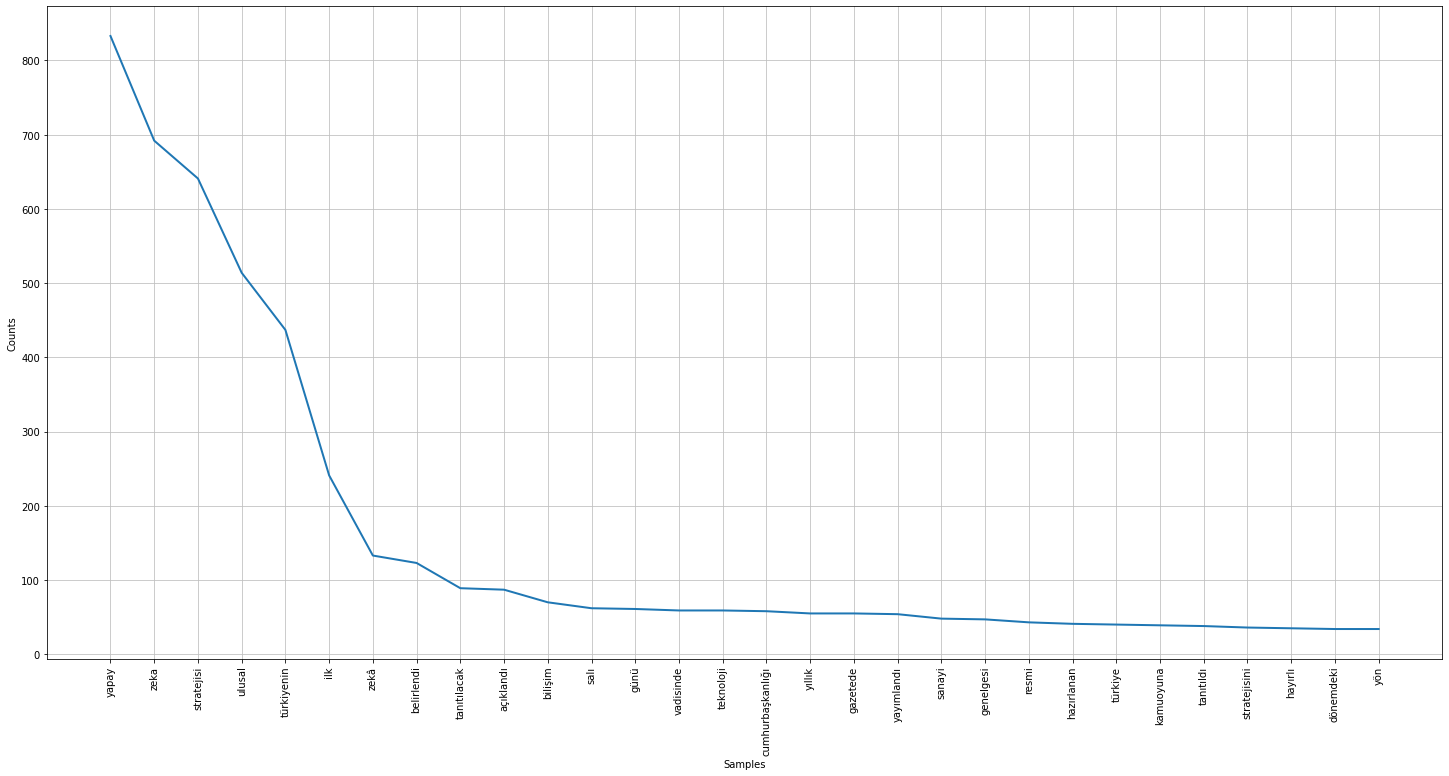

In [55]:
fdist_filtered = FreqDist(token_words_clean_)
#fdist_filtered.plot(30,title='Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')
plt.figure(figsize=(25, 12))
fdist_filtered.plot(30)

In [28]:
from collections import Counter

d = Counter(fdist_filtered)
d.most_common(30)

[('yapay', 833),
 ('zeka', 692),
 ('stratejisi', 641),
 ('ulusal', 514),
 ('t√ºrkiyenin', 437),
 ('ilk', 241),
 ('zek√¢', 133),
 ('belirlendi', 123),
 ('tanƒ±tƒ±lacak', 89),
 ('a√ßƒ±klandƒ±', 87),
 ('bili≈üim', 70),
 ('salƒ±', 62),
 ('g√ºn√º', 61),
 ('vadisinde', 59),
 ('teknoloji', 59),
 ('cumhurba≈ükanlƒ±ƒüƒ±', 58),
 ('yƒ±llƒ±k', 55),
 ('gazetede', 55),
 ('yayƒ±mlandƒ±', 54),
 ('sanayi', 48),
 ('genelgesi', 47),
 ('resmi', 43),
 ('hazƒ±rlanan', 41),
 ('t√ºrkiye', 40),
 ('kamuoyuna', 39),
 ('tanƒ±tƒ±ldƒ±', 38),
 ('stratejisini', 36),
 ('hayƒ±rlƒ±', 35),
 ('d√∂nemdeki', 34),
 ('y√∂n', 34)]

### Word Cloud

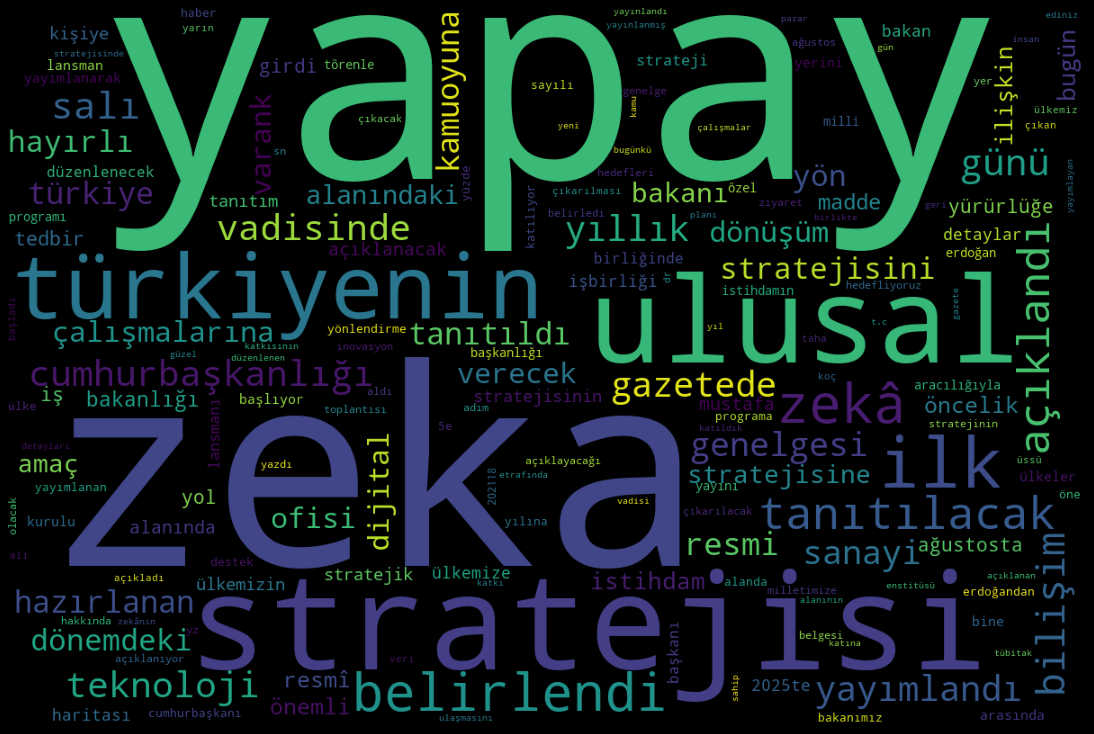

In [29]:
generate_word_cloud_from_frequencies(fdist_filtered, "all")

## POSITIVE

### Tokenizer

In [30]:
token_positive_words = word_tokenize(tweet_positive_texts)
print(token_positive_words)
print(len(token_positive_words))

['@', 'ZB6868', '@', 'firstjedii', '@', 'varank', 'Bence', 'biraz', 'abs√ºrd', 'bir', 'd√º≈ü√ºnce', 'bu', ':', ')', 'Yapay', 'zeka', '≈üuan', 'hayatƒ±mƒ±zda', 'zaten', 'mevcut', 'aslƒ±nda', '...', 'Bir', '√ßok', 'alanda', 'da', 'kullanƒ±yoruz', '.', 'Bizim', 'insanƒ±mƒ±zƒ±n', 'aklƒ±na', 'Yapay', 'Zeka', 'diyince', ',', 'insansƒ±', 'robotlar', 'geliyor', '...', 'Ama', 'bu', '√∂yle', 'bir', '≈üey', 'deƒüil', '.', 'Otonom', 'temelli', 'bir', 'yapay', 'zeka', 'stratejisi', 'konu≈üuluyor', ':', ')', 'T√ºrkiye', ',', 'yapay', 'zek√¢', 'stratejisini', 'yayƒ±mlayan', '√ºlkeler', 'arasƒ±nda', 'yerini', 'aldƒ±', '!', 'üáπüá∑T√ºrkiye', '‚Äô', 'nin', 'ilk', '‚Äú', 'Ulusal', 'Yapay', 'Zek√¢', 'Stratejisi', '‚Äù', 'yayƒ±mlandƒ±', '.', '√úlkemize', 'hayƒ±rlƒ±', 'olsun.üëèüèªTe≈üekk√ºrler', '@', 'dijital', '#', 'YapayZeka√áaƒüƒ±', 'https', ':', '//t.co/pSGZLl95KK', 'Ulusal', 'Yapay', 'Zeka', 'Stratejisi', 'Programƒ±', ',', 'savunma', 'sanayiinde', 'yapƒ±lanlar', ',', "ƒ∞HA'lar", ',', "Sƒ∞HA'lar", 

### Cleaner

In [31]:
tweet_positive_texts_clean = preprocess_tweet(tweet_positive_texts)
tweet_positive_texts_clean

'bence biraz abs√ºrd bir d√º≈ü√ºnce bu   yapay zeka ≈üuan hayatƒ±mƒ±zda zaten mevcut aslƒ±nda bir √ßok alanda da kullanƒ±yoruz  bizim insanƒ±mƒ±zƒ±n aklƒ±na yapay zeka diyince  insansƒ± robotlar geliyor ama bu √∂yle bir ≈üey deƒüil  otonom temelli bir yapay zeka stratejisi konu≈üuluyor   t√ºrkiye  yapay zek√¢ stratejisini yayƒ±mlayan √ºlkeler arasƒ±nda yerini aldƒ±  t√ºrkiyenin ilk ulusal yapay zek√¢ stratejisi yayƒ±mlandƒ±  √ºlkemize hayƒ±rlƒ± olsun.te≈üekk√ºrler ulusal yapay zeka stratejisi programƒ±  savunma sanayiinde yapƒ±lanlar  ihalar  sihalar  togg  selyangƒ±n afetlerinde g√∂sterilen √ºst√ºn gayretler  covid m√ºcadelesinde ve a≈üƒ±lamadaki ba≈üarƒ±  yenilenenyeni hastaneler ve daha neler neler ba≈ülƒ±yor ve i≈übirliƒüi ile hazƒ±rlanan t√ºrkiyenin ilk ulusal yapay zeka stratejisi  t√ºrkiyenin nde bug√ºn saat 10.00da a√ßƒ±klanacak  yapay zeka √ßaƒüi ile i≈übirliƒüinde hazƒ±rlanan t√ºrkiyenin ilk ulusal yapay zek√¢ stratejisi  teknoloji ve inovasyon √ºss√º tanƒ±tƒ±ldƒ±  adresinden

In [32]:
token_positive_words_clean = word_tokenize(tweet_positive_texts_clean)
print(token_positive_words_clean)
print(len(token_positive_words_clean))

['bence', 'biraz', 'abs√ºrd', 'bir', 'd√º≈ü√ºnce', 'bu', 'yapay', 'zeka', '≈üuan', 'hayatƒ±mƒ±zda', 'zaten', 'mevcut', 'aslƒ±nda', 'bir', '√ßok', 'alanda', 'da', 'kullanƒ±yoruz', 'bizim', 'insanƒ±mƒ±zƒ±n', 'aklƒ±na', 'yapay', 'zeka', 'diyince', 'insansƒ±', 'robotlar', 'geliyor', 'ama', 'bu', '√∂yle', 'bir', '≈üey', 'deƒüil', 'otonom', 'temelli', 'bir', 'yapay', 'zeka', 'stratejisi', 'konu≈üuluyor', 't√ºrkiye', 'yapay', 'zek√¢', 'stratejisini', 'yayƒ±mlayan', '√ºlkeler', 'arasƒ±nda', 'yerini', 'aldƒ±', 't√ºrkiyenin', 'ilk', 'ulusal', 'yapay', 'zek√¢', 'stratejisi', 'yayƒ±mlandƒ±', '√ºlkemize', 'hayƒ±rlƒ±', 'olsun.te≈üekk√ºrler', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'programƒ±', 'savunma', 'sanayiinde', 'yapƒ±lanlar', 'ihalar', 'sihalar', 'togg', 'selyangƒ±n', 'afetlerinde', 'g√∂sterilen', '√ºst√ºn', 'gayretler', 'covid', 'm√ºcadelesinde', 've', 'a≈üƒ±lamadaki', 'ba≈üarƒ±', 'yenilenenyeni', 'hastaneler', 've', 'daha', 'neler', 'neler', 'ba≈ülƒ±yor', 've', 'i≈übirliƒüi', 'ile', 'hazƒ±

### Clean Stop Words

In [33]:
token_positive_words_clean_ = [w for w in token_positive_words_clean if not w in stop_words]
print(token_positive_words_clean_)
print(len(token_positive_words_clean_))

['bence', 'abs√ºrd', 'd√º≈ü√ºnce', 'yapay', 'zeka', '≈üuan', 'hayatƒ±mƒ±zda', 'mevcut', 'alanda', 'kullanƒ±yoruz', 'insanƒ±mƒ±zƒ±n', 'aklƒ±na', 'yapay', 'zeka', 'diyince', 'insansƒ±', 'robotlar', 'geliyor', 'otonom', 'temelli', 'yapay', 'zeka', 'stratejisi', 'konu≈üuluyor', 't√ºrkiye', 'yapay', 'zek√¢', 'stratejisini', 'yayƒ±mlayan', '√ºlkeler', 'arasƒ±nda', 'yerini', 'aldƒ±', 't√ºrkiyenin', 'ilk', 'ulusal', 'yapay', 'zek√¢', 'stratejisi', 'yayƒ±mlandƒ±', '√ºlkemize', 'hayƒ±rlƒ±', 'olsun.te≈üekk√ºrler', 'ulusal', 'yapay', 'zeka', 'stratejisi', 'programƒ±', 'savunma', 'sanayiinde', 'yapƒ±lanlar', 'ihalar', 'sihalar', 'togg', 'selyangƒ±n', 'afetlerinde', 'g√∂sterilen', '√ºst√ºn', 'gayretler', 'covid', 'm√ºcadelesinde', 'a≈üƒ±lamadaki', 'ba≈üarƒ±', 'yenilenenyeni', 'hastaneler', 'neler', 'neler', 'ba≈ülƒ±yor', 'i≈übirliƒüi', 'hazƒ±rlanan', 't√ºrkiyenin', 'ilk', 'ulusal', 'yapay', 'zeka', 'stratejisi', 't√ºrkiyenin', 'bug√ºn', 'a√ßƒ±klanacak', 'yapay', 'zeka', '√ßaƒüi', 'i≈übirliƒüinde', '

### Words Frequency

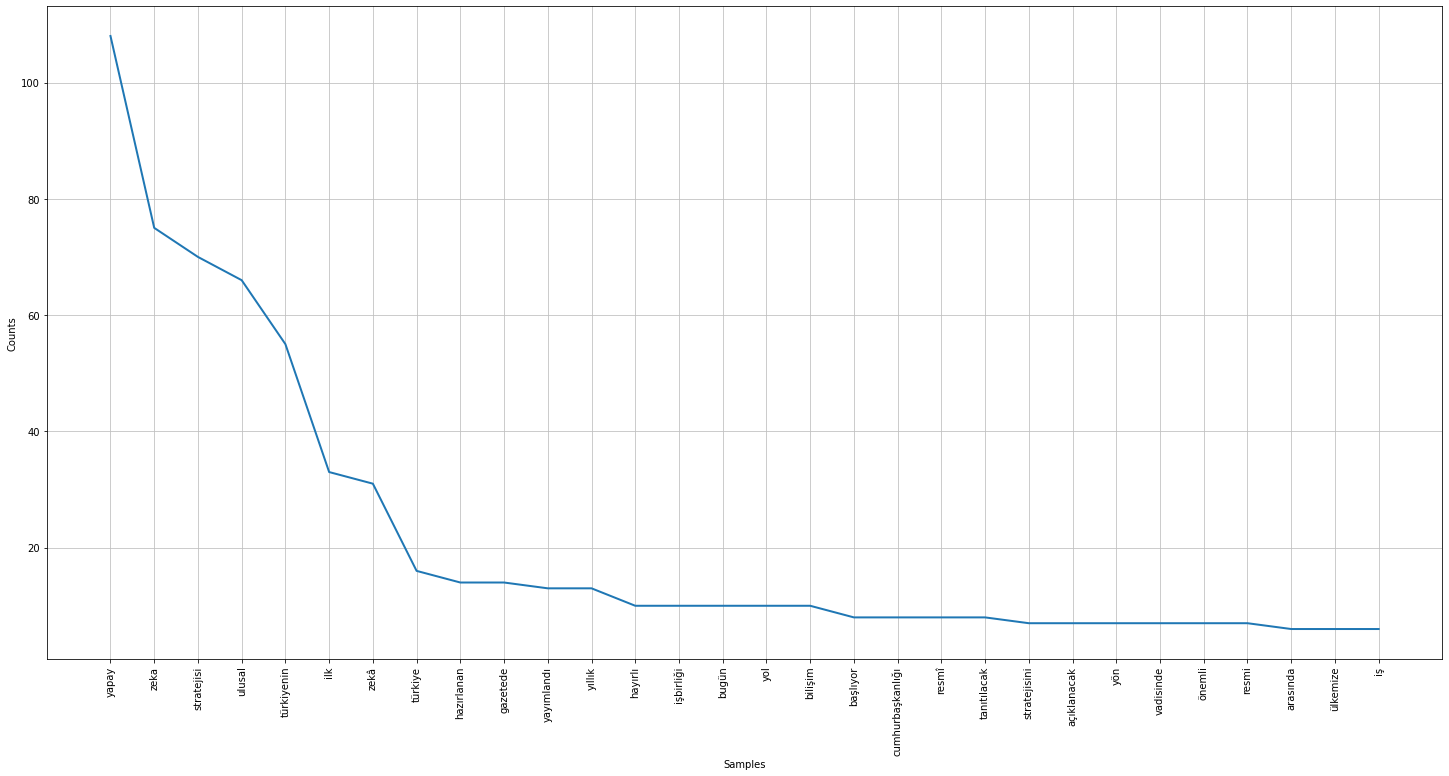

In [56]:
fdist_filtered_positive = FreqDist(token_positive_words_clean_)
#fdist_filtered_positive.plot(30,title='POSITIVE - Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')
plt.figure(figsize=(25, 12))
fdist_filtered_positive.plot(30)

In [35]:
d = Counter(fdist_filtered_positive)
d.most_common(30)

[('yapay', 108),
 ('zeka', 75),
 ('stratejisi', 70),
 ('ulusal', 66),
 ('t√ºrkiyenin', 55),
 ('ilk', 33),
 ('zek√¢', 31),
 ('t√ºrkiye', 16),
 ('hazƒ±rlanan', 14),
 ('gazetede', 14),
 ('yayƒ±mlandƒ±', 13),
 ('yƒ±llƒ±k', 13),
 ('hayƒ±rlƒ±', 10),
 ('i≈übirliƒüi', 10),
 ('bug√ºn', 10),
 ('yol', 10),
 ('bili≈üim', 10),
 ('ba≈ülƒ±yor', 8),
 ('cumhurba≈ükanlƒ±ƒüƒ±', 8),
 ('resm√Æ', 8),
 ('tanƒ±tƒ±lacak', 8),
 ('stratejisini', 7),
 ('a√ßƒ±klanacak', 7),
 ('y√∂n', 7),
 ('vadisinde', 7),
 ('√∂nemli', 7),
 ('resmi', 7),
 ('arasƒ±nda', 6),
 ('√ºlkemize', 6),
 ('i≈ü', 6)]

### Word Cloud

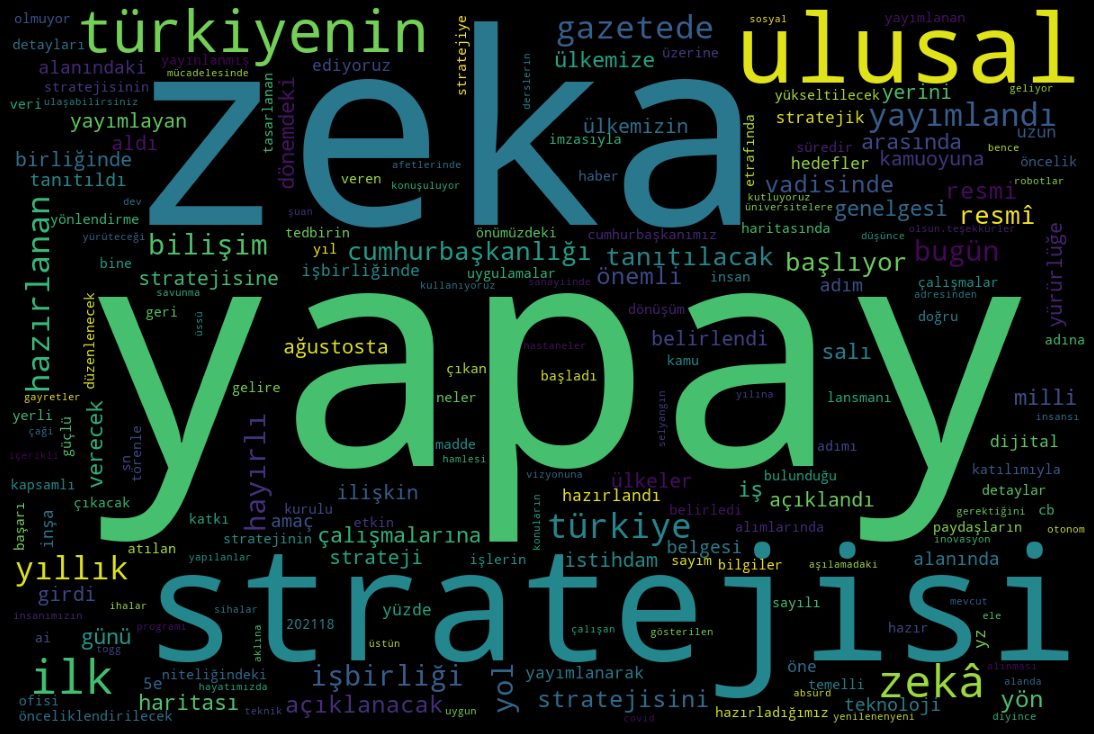

In [36]:
generate_word_cloud_from_frequencies(fdist_filtered_positive, "positive")

## NEGATIVE

### Tokenizer

In [37]:
token_negative_words = word_tokenize(tweet_negative_texts)
print(token_negative_words)
print(len(token_negative_words))

['F√ºsun', 'Sarp', 'Nebil', 'yazdƒ±', ':', 'Yapay', 'zek√¢', 'stratejisi', 'g√ºzel', 'ama', 'altyapƒ±sƒ±', 'yok', 'https', ':', '//t.co/Lm8ZFKjMgp', 'https', ':', '//t.co/EDrJo8mWVu', 'Sabƒ±rla', 'dinledim', 'konu≈ümalarƒ±', 've', '√ßok', 'sƒ±ƒü', 'buldum', '!', '√úlkenin', 'yapay', 'zeka', 'stratejisi', 'ya', 'da', 'vizyonuna', 'ili≈ükin', 'tek', 'bir', 'c√ºmle', 'yok', '!', 'Yapay', 'zeka', 'dediƒüiniz', 'bir', 'algoritma', '!', '√úlke', 'olarak', 'ihtiyacƒ±mƒ±z', 'olan', '≈üey', 'milli', 'bir', 'ƒ∞≈ületim', 'Sistemi..', '!', '1', 'Yƒ±l', '√ñnce', 'de', '1', 'Milyon', 'Yazƒ±lƒ±mcƒ±', 'Yeti≈ütireceƒüiz', 'Denilmi≈üti', 'Nerede', 'O', 'Yazƒ±lƒ±mcƒ±lar', '?', 'Yapay', 'Zeka', 'Stratejisi', 'A√ßƒ±klandƒ±', 'da', 'Alt', 'Yapƒ±', 'Nerede', '?', 'Veri', 'Merkezi', 'Nerede', '?', ')', '(', 'Ciddiyet', 'ƒ∞steyen', 'Konularda', 'Bile', 'Gev≈üeklik', ';', 'Olgudan', '√áok', 'Uzak', 'Algƒ±', ',', 'Tek', 'Dertleri', 'Oy', '...', 'https', ':', '//t.co/QYWZXyz3k9', 'Yapay', 'zeka', 'stratejisi', 'd

### Cleaner

In [38]:
tweet_negative_texts_clean = preprocess_tweet(tweet_negative_texts)
tweet_negative_texts_clean

'f√ºsun sarp nebil yazdƒ±  yapay zek√¢ stratejisi g√ºzel ama altyapƒ±sƒ± yok sabƒ±rla dinledim konu≈ümalarƒ± ve √ßok sƒ±ƒü buldum  √ºlkenin yapay zeka stratejisi ya da vizyonuna ili≈ükin tek bir c√ºmle yok  yapay zeka dediƒüiniz bir algoritma  √ºlke olarak ihtiyacƒ±mƒ±z olan ≈üey milli bir i≈ületim sistemi  yƒ±l √∂nce de milyon yazƒ±lƒ±mcƒ± yeti≈ütireceƒüiz denilmi≈üti nerede o yazƒ±lƒ±mcƒ±lar  yapay zeka stratejisi a√ßƒ±klandƒ± da alt yapƒ± nerede  veri merkezi nerede    ciddiyet isteyen konularda bile gev≈üeklik  olgudan √ßok uzak algƒ±  tek dertleri oy yapay zeka stratejisi dok√ºmanƒ±na bakƒ±yorduk  yapay zeka daire ba≈ükanlƒ±ƒüƒ±nƒ± g√∂r√ºnce durduk  daire ba≈ükanƒ± ibm watson olsun  makam odasƒ±  makam arabasƒ±  ≈üof√∂r  koruma  sekreter  √ßaycƒ±  maa≈ü  ikramiye  kƒ±dem tazminatƒ± istemez yapay zeka stratejisi g√ºzel bir giri≈üim olabilir  tarafsƒ±z g√∂zle bakayƒ±m belki ger√ßekten bir √ßaba vardƒ±r diye oturdum lansmanƒ± izledim  g√∂zlemim  ya ingilizce nlp modellerine parmak ƒ±

In [39]:
token_negative_words_clean = word_tokenize(tweet_negative_texts_clean)
print(token_negative_words_clean)
print(len(token_negative_words_clean))

['f√ºsun', 'sarp', 'nebil', 'yazdƒ±', 'yapay', 'zek√¢', 'stratejisi', 'g√ºzel', 'ama', 'altyapƒ±sƒ±', 'yok', 'sabƒ±rla', 'dinledim', 'konu≈ümalarƒ±', 've', '√ßok', 'sƒ±ƒü', 'buldum', '√ºlkenin', 'yapay', 'zeka', 'stratejisi', 'ya', 'da', 'vizyonuna', 'ili≈ükin', 'tek', 'bir', 'c√ºmle', 'yok', 'yapay', 'zeka', 'dediƒüiniz', 'bir', 'algoritma', '√ºlke', 'olarak', 'ihtiyacƒ±mƒ±z', 'olan', '≈üey', 'milli', 'bir', 'i≈ületim', 'sistemi', 'yƒ±l', '√∂nce', 'de', 'milyon', 'yazƒ±lƒ±mcƒ±', 'yeti≈ütireceƒüiz', 'denilmi≈üti', 'nerede', 'o', 'yazƒ±lƒ±mcƒ±lar', 'yapay', 'zeka', 'stratejisi', 'a√ßƒ±klandƒ±', 'da', 'alt', 'yapƒ±', 'nerede', 'veri', 'merkezi', 'nerede', 'ciddiyet', 'isteyen', 'konularda', 'bile', 'gev≈üeklik', 'olgudan', '√ßok', 'uzak', 'algƒ±', 'tek', 'dertleri', 'oy', 'yapay', 'zeka', 'stratejisi', 'dok√ºmanƒ±na', 'bakƒ±yorduk', 'yapay', 'zeka', 'daire', 'ba≈ükanlƒ±ƒüƒ±nƒ±', 'g√∂r√ºnce', 'durduk', 'daire', 'ba≈ükanƒ±', 'ibm', 'watson', 'olsun', 'makam', 'odasƒ±', 'makam', 'arabasƒ±',

### Clean Stop Words

In [40]:
token_negative_words_clean_ = [w for w in token_negative_words_clean if not w in stop_words]
print(token_negative_words_clean_)
print(len(token_negative_words_clean_))

['f√ºsun', 'sarp', 'nebil', 'yazdƒ±', 'yapay', 'zek√¢', 'stratejisi', 'g√ºzel', 'altyapƒ±sƒ±', 'sabƒ±rla', 'dinledim', 'konu≈ümalarƒ±', 'sƒ±ƒü', 'buldum', '√ºlkenin', 'yapay', 'zeka', 'stratejisi', 'vizyonuna', 'ili≈ükin', 'tek', 'c√ºmle', 'yapay', 'zeka', 'dediƒüiniz', 'algoritma', '√ºlke', 'ihtiyacƒ±mƒ±z', 'milli', 'i≈ületim', 'sistemi', 'yƒ±l', 'yazƒ±lƒ±mcƒ±', 'yeti≈ütireceƒüiz', 'denilmi≈üti', 'yazƒ±lƒ±mcƒ±lar', 'yapay', 'zeka', 'stratejisi', 'a√ßƒ±klandƒ±', 'alt', 'yapƒ±', 'veri', 'merkezi', 'ciddiyet', 'isteyen', 'konularda', 'gev≈üeklik', 'olgudan', 'uzak', 'algƒ±', 'tek', 'dertleri', 'oy', 'yapay', 'zeka', 'stratejisi', 'dok√ºmanƒ±na', 'bakƒ±yorduk', 'yapay', 'zeka', 'daire', 'ba≈ükanlƒ±ƒüƒ±nƒ±', 'g√∂r√ºnce', 'durduk', 'daire', 'ba≈ükanƒ±', 'ibm', 'watson', 'makam', 'odasƒ±', 'makam', 'arabasƒ±', '≈üof√∂r', 'koruma', 'sekreter', '√ßaycƒ±', 'maa≈ü', 'ikramiye', 'kƒ±dem', 'tazminatƒ±', 'istemez', 'yapay', 'zeka', 'stratejisi', 'g√ºzel', 'giri≈üim', 'olabilir', 'tarafsƒ±z', 'g√∂zl

### Words Frequency

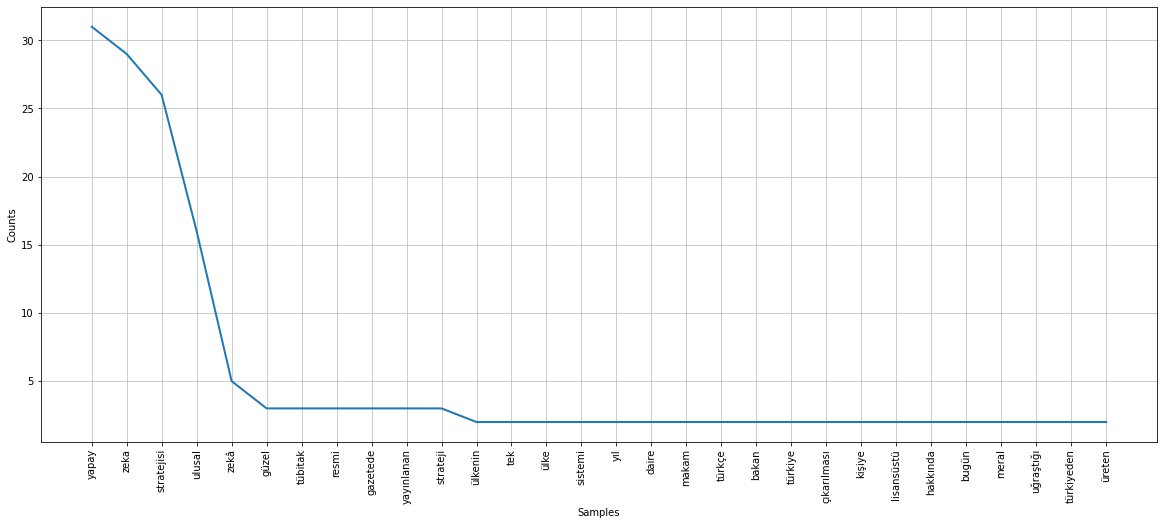

In [41]:
fdist_filtered_negative = FreqDist(token_negative_words_clean_)
#fdist_filtered_negative.plot(30,title='NEGATIVE - Frequency distribution for 30 most common tokens in our text collection (excluding stopwords and punctuation)')
plt.figure(figsize=(20, 8))
fdist_filtered_negative.plot(30)

In [42]:
d = Counter(fdist_filtered_negative)
d.most_common(30)

[('yapay', 31),
 ('zeka', 29),
 ('stratejisi', 26),
 ('ulusal', 16),
 ('zek√¢', 5),
 ('g√ºzel', 3),
 ('t√ºbitak', 3),
 ('resmi', 3),
 ('gazetede', 3),
 ('yayƒ±nlanan', 3),
 ('strateji', 3),
 ('√ºlkenin', 2),
 ('tek', 2),
 ('√ºlke', 2),
 ('sistemi', 2),
 ('yƒ±l', 2),
 ('daire', 2),
 ('makam', 2),
 ('t√ºrk√ße', 2),
 ('bakan', 2),
 ('t√ºrkiye', 2),
 ('√ßƒ±karƒ±lmasƒ±', 2),
 ('ki≈üiye', 2),
 ('lisans√ºst√º', 2),
 ('hakkƒ±nda', 2),
 ('bug√ºn', 2),
 ('meral', 2),
 ('uƒüra≈ütƒ±ƒüƒ±', 2),
 ('t√ºrkiyeden', 2),
 ('√ºreten', 2)]

### Word Cloud

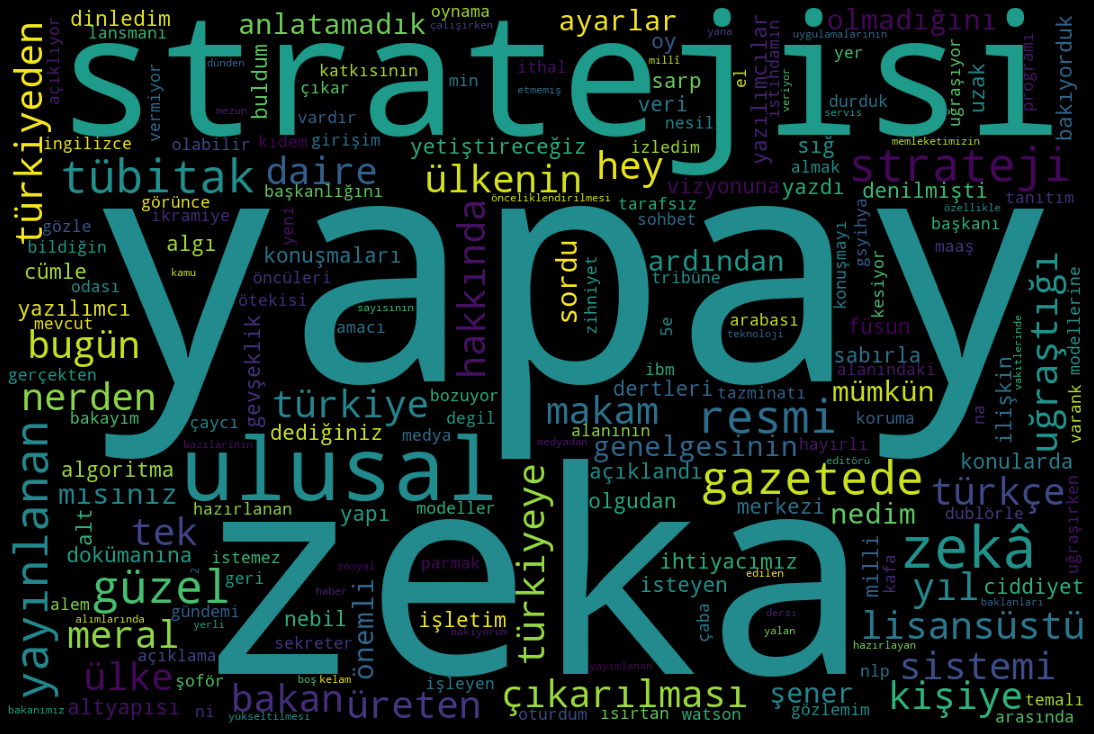

In [43]:
generate_word_cloud_from_frequencies(fdist_filtered_negative, "negative")

# DIFF

In [ ]:
diff_only_positive = set(token_positive_words) - set(token_negative_words)
diff_only_positive

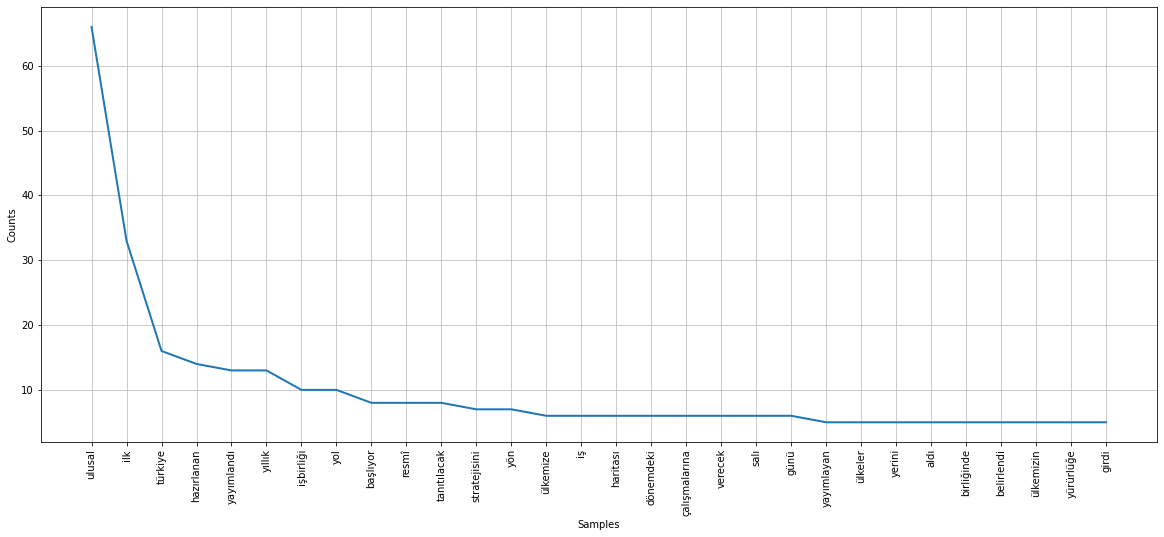

In [45]:
only_positive = []
for positive_word in token_positive_words_clean_:
  if positive_word in diff_only_positive:
    only_positive.append(positive_word)


fdist_filtered_only_positive = FreqDist(only_positive)
plt.figure(figsize=(20, 8))
fdist_filtered_only_positive.plot(30)

In [46]:
d = Counter(only_positive)
d.most_common(30)

[('ulusal', 66),
 ('ilk', 33),
 ('t√ºrkiye', 16),
 ('hazƒ±rlanan', 14),
 ('yayƒ±mlandƒ±', 13),
 ('yƒ±llƒ±k', 13),
 ('i≈übirliƒüi', 10),
 ('yol', 10),
 ('ba≈ülƒ±yor', 8),
 ('resm√Æ', 8),
 ('tanƒ±tƒ±lacak', 8),
 ('stratejisini', 7),
 ('y√∂n', 7),
 ('√ºlkemize', 6),
 ('i≈ü', 6),
 ('haritasƒ±', 6),
 ('d√∂nemdeki', 6),
 ('√ßalƒ±≈ümalarƒ±na', 6),
 ('verecek', 6),
 ('salƒ±', 6),
 ('g√ºn√º', 6),
 ('yayƒ±mlayan', 5),
 ('√ºlkeler', 5),
 ('yerini', 5),
 ('aldƒ±', 5),
 ('birliƒüinde', 5),
 ('belirlendi', 5),
 ('√ºlkemizin', 5),
 ('y√ºr√ºrl√ºƒüe', 5),
 ('girdi', 5)]

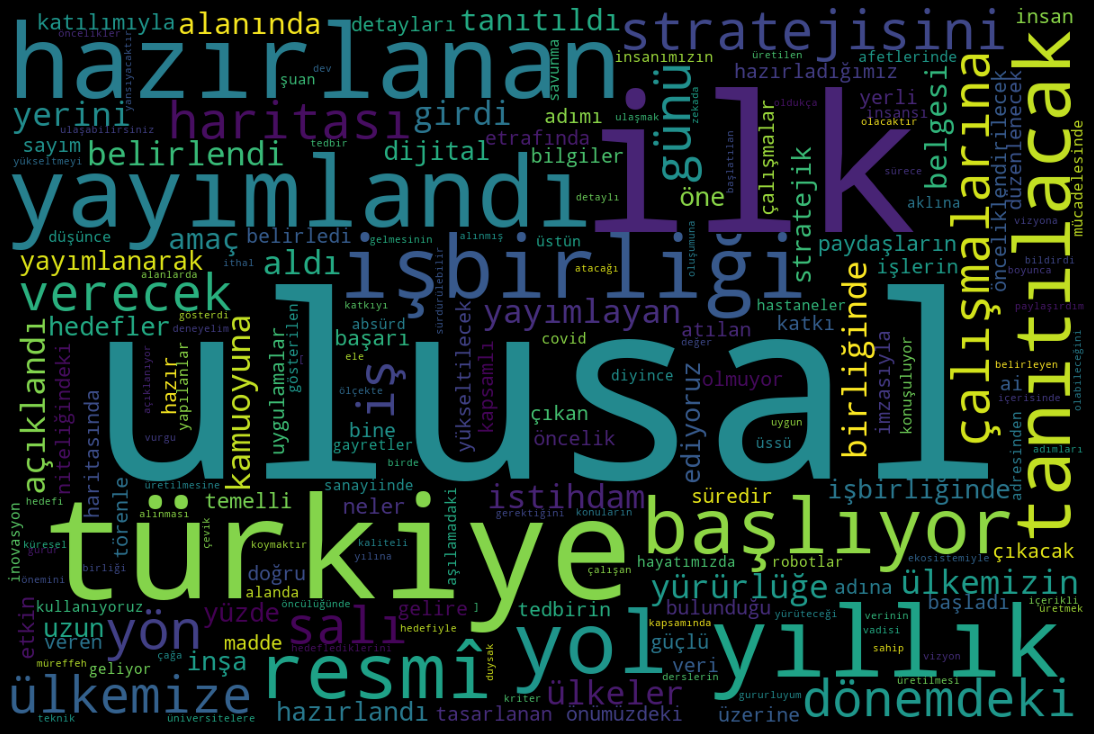

In [47]:
generate_word_cloud_from_frequencies(fdist_filtered_only_positive, "only_positive")

In [ ]:
diff_only_negative = set(token_negative_words) - set(token_positive_words)
diff_only_negative

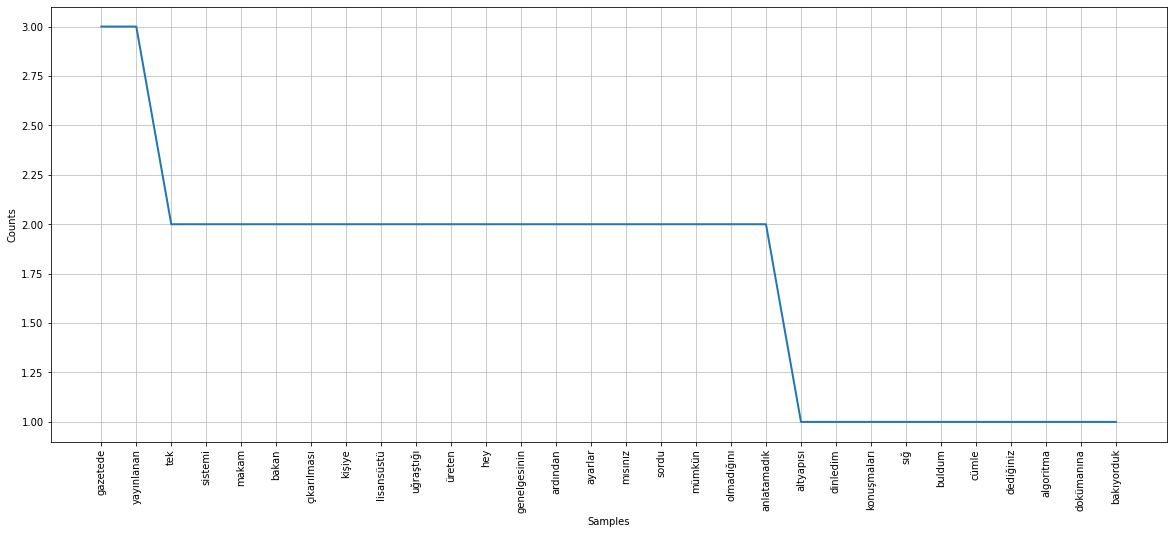

In [49]:
only_negative = []
for negative_word in token_negative_words_clean_:
  if negative_word in diff_only_negative:
    only_negative.append(negative_word)


fdist_filtered_only_negative = FreqDist(only_negative)
plt.figure(figsize=(20, 8))
fdist_filtered_only_negative.plot(30)

In [50]:
d = Counter(only_negative)
d.most_common(30)

[('gazetede', 3),
 ('yayƒ±nlanan', 3),
 ('tek', 2),
 ('sistemi', 2),
 ('makam', 2),
 ('bakan', 2),
 ('√ßƒ±karƒ±lmasƒ±', 2),
 ('ki≈üiye', 2),
 ('lisans√ºst√º', 2),
 ('uƒüra≈ütƒ±ƒüƒ±', 2),
 ('√ºreten', 2),
 ('hey', 2),
 ('genelgesinin', 2),
 ('ardƒ±ndan', 2),
 ('ayarlar', 2),
 ('mƒ±sƒ±nƒ±z', 2),
 ('sordu', 2),
 ('m√ºmk√ºn', 2),
 ('olmadƒ±ƒüƒ±nƒ±', 2),
 ('anlatamadƒ±k', 2),
 ('altyapƒ±sƒ±', 1),
 ('dinledim', 1),
 ('konu≈ümalarƒ±', 1),
 ('sƒ±ƒü', 1),
 ('buldum', 1),
 ('c√ºmle', 1),
 ('dediƒüiniz', 1),
 ('algoritma', 1),
 ('dok√ºmanƒ±na', 1),
 ('bakƒ±yorduk', 1)]

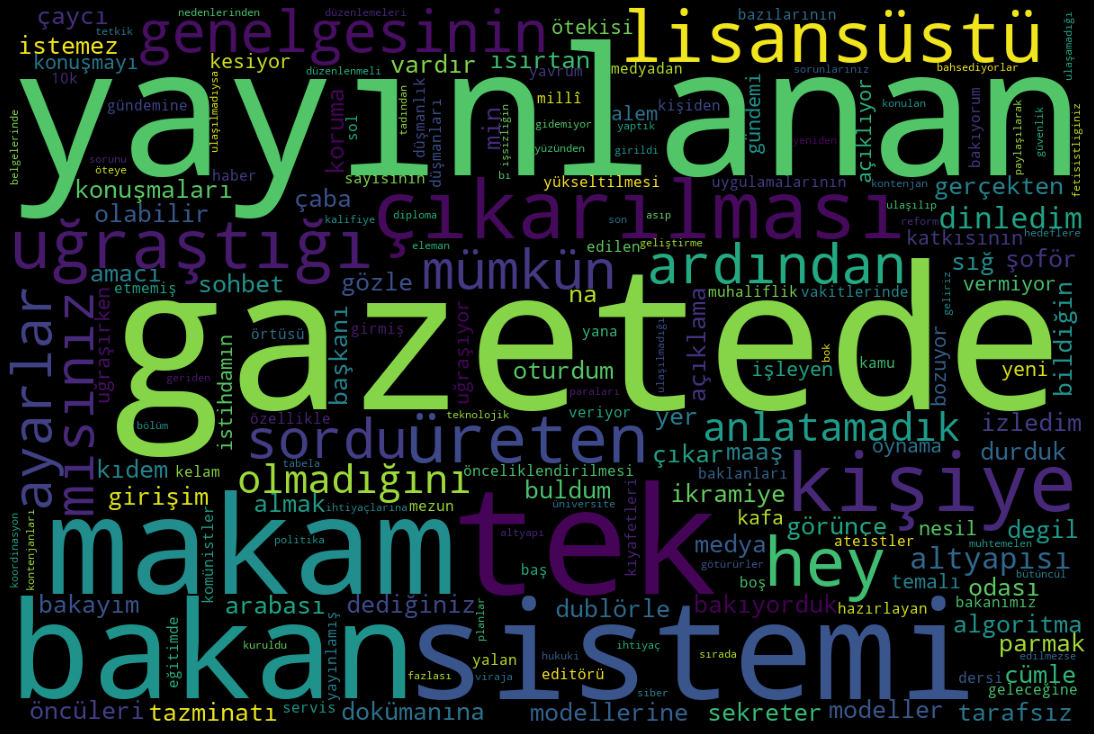

In [51]:
generate_word_cloud_from_frequencies(fdist_filtered_only_negative, "only_negative")